In [5]:
import numpy as np


import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy.optimize import linear_sum_assignment
%matplotlib inline
from time import time
   
from PIL import Image
import numpy as np


In [6]:
from scipy.special import logsumexp
def sinkhorn(log_alpha, n_iters=20):

    for n in range(n_iters):
        log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
        log_alpha -= logsumexp(log_alpha, axis=0, keepdims=True)
        if n%10000==1:
            print(n)
    log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
    return np.exp(log_alpha)

def batch_split(batch, n_squares_side, n_channels=1):
    if(n_channels ==1):
        side = int(np.sqrt(batch.shape[1]))
    else:
        side = batch.shape[1]
    batch_size = batch.shape[0]
    n_squares = n_squares_side ** 2
    
    batch = np.reshape(batch, [-1, side, side, n_channels])
    batch = np.reshape(batch, [batch_size, n_squares_side, side/n_squares_side, side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    batch = np.reshape(batch, [batch_size, side/n_squares_side, n_squares, side/n_squares_side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    return batch

def stack_batch_split(batch):
    return np.reshape(batch, [batch.shape[0]*batch.shape[1], batch.shape[2], batch.shape[3], batch.shape[4]])


def unflatten_batch(batch, n_channels=1):
    side_square = int(np.sqrt(batch.shape[2]/n_channels))
    return np.reshape(batch, [batch.shape[0], batch.shape[1], side_square, side_square, n_channels])

def join_batch_split(batch):
    batch_size = batch.shape[0]
    n_squares = batch.shape[1]
    side_quare = batch.shape[2]
    n_channels = batch.shape[4]
    n_squares_side = int(np.sqrt(n_squares))
    batch = np.transpose(batch, [0, 1, 3, 2, 4])
    batch = np.reshape(batch, [batch_size, n_squares_side, side_square*n_squares_side, side_square, n_channels])
    batch = np.transpose(batch, [0,1, 3,2,4])
    batch = np.reshape(batch, [batch_size, 1, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    batch = np.reshape(batch, [batch_size, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    return batch

def resized_dims(n_squares_side):
    if(n_squares_side==2):
        side = 28
        side_square = 14
    if(n_squares_side==3):
        side = 27
        side_square = 9
    if(n_squares_side==4):
        side = 28
        side_square = 7
    if(n_squares_side==5):
        side = 30
        side_square = 6
    if(n_squares_side==6):
        side = 30
        side_square = 5
    if(n_squares_side==7):
        side = 28
        side_square = 4
    if(n_squares_side==8):
        side = 32
        side_square = 4
    if(n_squares_side==9):
        side = 27
        side_square = 3
    if(n_squares_side==16):
        side = 160
        side_square = 10
    if(n_squares_side==14):
        side = 196
        side_square = 14
    if(n_squares_side==18):
        side = 8*18
        side_square = 8
    if(n_squares_side==20):
        side = 7*20
        side_square = 7
    if(n_squares_side==25):
        side = 25*6
        side_square = 6
    if(n_squares_side==30):
        side = 30*5
        side_square = 5
    if (n_squares_side == 37):
        side = 37 * 4
        side_square = 4
    if (n_squares_side == 45):
        side = 45 * 3
        side_square = 3
    return side, side_square

def resize_batch_color(batch, side_new, n_channels):
    batch_new = np.zeros((batch.shape[0], side_new, side_new, n_channels))
    side = int(np.sqrt(batch.shape[1]))
    for i in range(batch.shape[0]):
        for c in range(n_channels):
            a = imresize(batch[i,:,:,c], [side_new, side_new])
            
            a = a/255.0
            batch_new[i,:,:,c] =a
    return batch_new


def soft_to_hard(soft_perm):
    
    a,b = linear_sum_assignment(-soft_perm)
    ma = np.zeros((np.shape(soft_perm)))
    for i in range(soft_perm.shape[0]):
        ma[i, b[i]] = 1
    return ma


def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data


In [13]:
#Now we define the main TF variables
from copy import deepcopy
def solve(scrambled_split,stack_scrambled_images_split,stack_real_images_split):
    
    
    log_alpha = np.reshape(stack_scrambled_images_split, [batch_size, n_squares, n_dim])
    log_alpha2 = np.reshape(stack_real_images_split, [batch_size, n_squares, n_dim])



    sq = np.sum(log_alpha **2, axis=2, keepdims=True)
    A = np.tile(sq, [1, 1, n_squares])
    B = np.tile(np.transpose(sq, [0,2 ,1]), [1, n_squares, 1])
    C = -2*np.matmul(log_alpha, np.transpose(log_alpha, [0, 2, 1]))
    s1 = A+B +C
    sq2 = np.sum(log_alpha2 **2, axis=2, keepdims=True)
    A2 = np.tile(sq2, [1, 1, n_squares])
    B2 = np.tile(np.transpose(sq2, [0,2 ,1]), [1, n_squares, 1])
    C2 = np.matmul(-2*log_alpha2, np.transpose(log_alpha2, [0, 2, 1]))
    s2 = A2+B2 +C2
    f1 = np.tile(np.sum(s1**2, axis=2, keepdims=True),[1, 1, n_squares]) 
    f2 = np.transpose(np.tile(np.sum(s2**2, axis=2, keepdims=True),[1, 1, n_squares]), [0, 2 ,1]) 
    
    P = np.tile(np.eye(n_squares)[np.newaxis,:,:], [batch_size, 1, 1])
    
    invP_all = []
    ma_all = []
        
    for l in range(n_gromov):
        invP_all.append(deepcopy(np.transpose(P, [0, 2,1])))
     
        ma = -1*(f1+f2 - 2*np.matmul(s1, np.matmul(P, s2)))
        ma_all.append(ma)
        
        
        for k in range(batch_size):
            #print([l,k, s1.shape])
            #P[k,:,:] = sinkhorn(ma[k,:,:]/temp, n_iters = n_iter_sinkhorn)
            a=time()
            if(l<=100):
                P[k,:,:] = sinkhorn(ma[k,:,:]/temp, n_iters = n_iter_sinkhorn)
                print([np.percentile(np.sum(P[k,:,:], axis=0), 5), np.percentile(np.sum(P[k,:,:], axis=0),95)])
            else:
                P[k,:,:] = soft_to_hard(ma[k,:,:])
            print(time()-a)
    invP_all.append(deepcopy(np.transpose(P, [0, 2,1])))
        
    
    inv_P = np.transpose(P, [0, 2,1])
   
    scrambled_split_tiled = np.reshape(scrambled_split, [batch_size, n_squares, side_square ** 2* n_channels])

    ordered_inf = np.matmul(inv_P, scrambled_split_tiled)

    return ordered_inf,inv_P, invP_all,ma_all

In [ ]:
#Define model params
batch_size = 1
batch_size_display = batch_size
n_iter_sinkhorn = 1000

temp = 100.0

#mnist data
n_squares_side = 30
n_channels = 3

n_squares = n_squares_side **2
n_gromov = 6
side, side_square = resized_dims(n_squares_side)
n_dim = int(side_square*side_square*n_channels)
str1='tobar4'
str2='fontbona3'
im1 = load_image(str1+'.jpg')[np.newaxis,:,:,:]
im2 = load_image(str2+'.jpg')[np.newaxis,:,:,:]
fig, ax = plt.subplots(1,n_gromov+2,figsize=(20,20))
inv_perms =[]
sip=[]


np_x = im1
np_x2 = im2
np_x = resize_batch_color(np_x, side, n_channels)

np_x2 = resize_batch_color(np_x2, side, n_channels)

real_images_split = batch_split(np_x, n_squares_side, n_channels)
real_images_split2 = batch_split(np_x2, n_squares_side, n_channels)

scrambled_images_split = np.zeros(real_images_split.shape)




perm = np.arange(n_squares)
np.random.seed(1)
perm = np.random.permutation(n_squares)
i=0
scrambled_images_split[i,:, :, :] = real_images_split[i, perm, :, :]
stacked_scrambled_images_split = stack_batch_split(scrambled_images_split)
stacked_real_images_split = stack_batch_split(real_images_split2)


unscrambled_images, inv_soft_perms_np,invP_all,ma_all=solve(scrambled_images_split,
                                                            stacked_scrambled_images_split,
                                                            stacked_real_images_split)

unscrambled_images = unscrambled_images[:batch_size_display,:,:]
unflatten_inf = unflatten_batch(unscrambled_images, n_channels)


joined_inf = join_batch_split(unflatten_inf)
joined_scrambled = join_batch_split(scrambled_images_split)
joined_real = join_batch_split(real_images_split2)

#Compare reconstructions with real data




a=time()
ax[0].imshow(joined_real[i,:,:,:],cmap='Greys')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

for l in range(n_gromov+1):
    inv_hard_perms= np.zeros((batch_size_display, n_squares, n_squares))
    a=time()
    if(l<=5):
        inv_hard_perms[i,:,:] = invP_all[l][i,:,:] 
    else:
        inv_hard_perms[i,:,:] = soft_to_hard(invP_all[l][i,:,:])
           
    inv_perms.append(inv_hard_perms)
    print(time()-a)



    hard_inf = np.matmul(inv_hard_perms, np.reshape(scrambled_images_split[:batch_size_display,:,:,:], [batch_size_display,n_squares_side **2 ,-1]))
    unflatten_hard_inf =np.reshape(hard_inf, unflatten_inf.shape)
    joined_hard_inf =join_batch_split(unflatten_hard_inf)

    
    ax[l+1].imshow(joined_hard_inf[i,:,:,:],cmap='Greys')
    ax[l+1].get_xaxis().set_visible(False)
    ax[l+1].get_yaxis().set_visible(False)


/Users/gonzalomena/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


1
[0.9603346478435244, 1.0754347154063317]
17.5208990574
1
[0.7644535349281706, 1.1642948230097887]
30.4163980484
1
[0.5368840040298059, 1.5183905276568421]
33.7639119625
1


57.6461091042


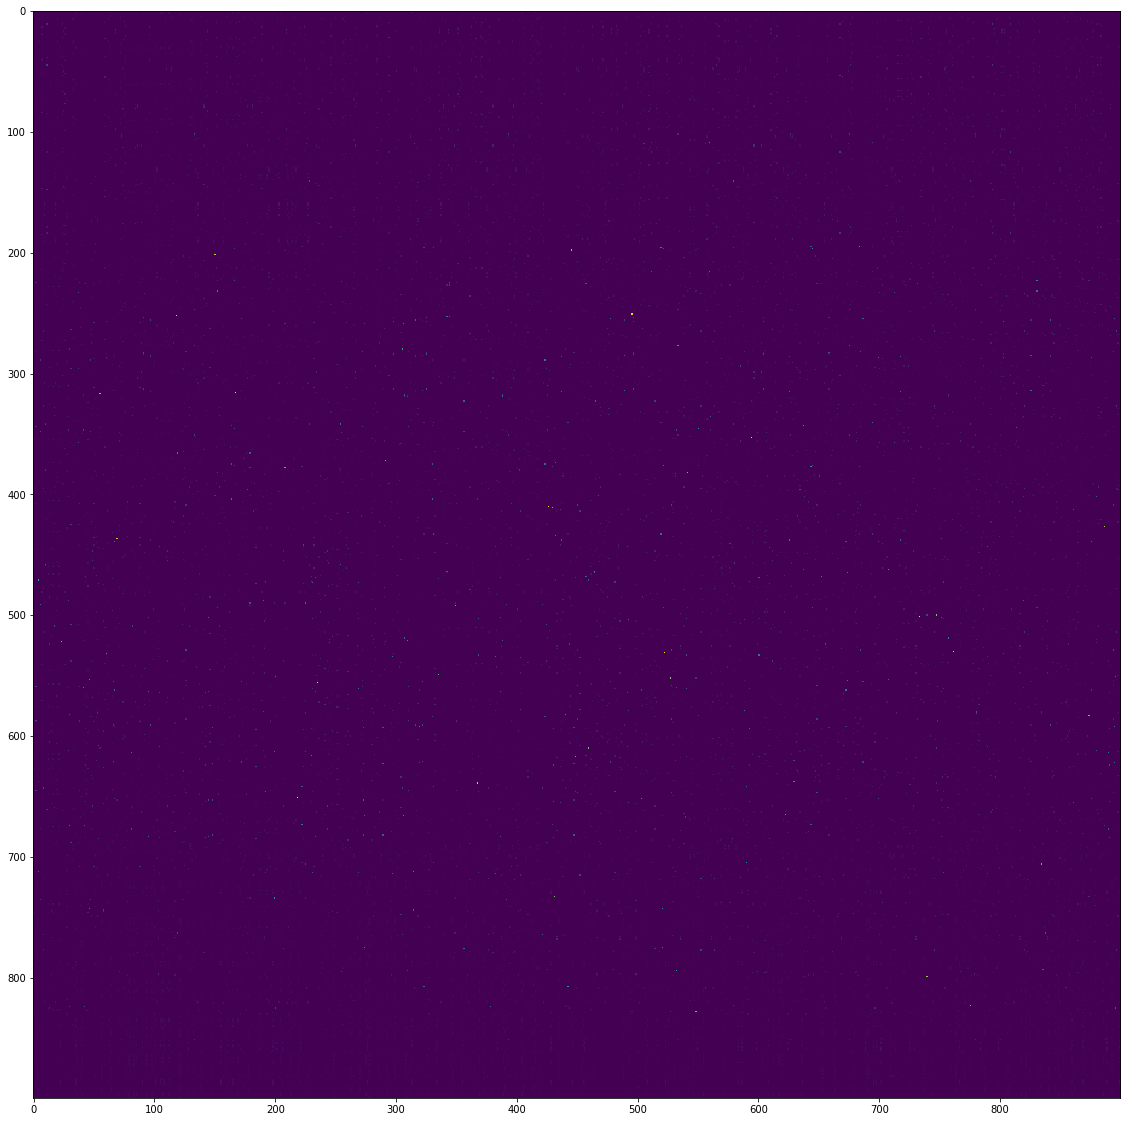

In [36]:
#print(np.sum(invP_all[1][0,:,:],axis=1))
plt.figure(figsize=(20,20))
plt.imshow(invP_all[-1][0,:,:])
a=time()
aa=soft_to_hard(invP_all[-1][0,:,:])
print(time()-a)

In [53]:
inv_hard = np.eye(n_squares)
sample = np.random.permutation(n_squares)
ims=[]
for k in range(n_squares):
    inv_hard[sample[k], sample[k]] = 0
    l = np.where(inv_perms[0][0, sample[k], :]==1)[0][0]
    inv_hard[sample[k], l] = 1

    im = np.matmul(inv_hard[np.newaxis,:,:], np.reshape(sip[0][:batch_size_display,:,:,:], [batch_size_display,n_squares_side **2 ,-1]))
    unflatten_hard_inf =np.reshape(im, unflatten_inf.shape)
    joined_hard_inf =join_batch_split(unflatten_hard_inf)
    ims.append(joined_hard_inf)

IndexError: list index out of range

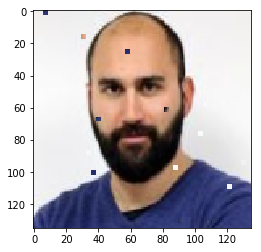

In [14]:
plt.imshow(ims[14][0,:,:])

In [15]:
print(ims[0].shape)

(1, 135, 135, 3)


In [10]:
animated_gif.save('hola')
